# Support Vector Machine (SVM) Modeling

In this notebook, we iterate through an SVM baseline, trying different class imbalance remedy methods. We also grid search to try and optomize the baseline's hyperparameters.

The idea behind SVMs is that you perform classification by finding the seperation line or (in higher dimensions) 'hyperplane' that maximizes the distance between two classes.

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns; sns.set()
%matplotlib inline
import nltk
from sklearn.feature_extraction import text 
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn import metrics, model_selection, svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix, roc_curve, auc, classification_report
import pickle

## Importing X and y from `nlp_preprocessing.ipynb`

In [17]:
X_lem = pickle.load(open('../pickle/X_lem.pkl', 'rb'))
y_lem = pd.read_pickle('../pickle/y_lem.pkl')

In [18]:
# setting up stop words
stop_words = set(stopwords.words('english'))

## Train-Test Split & Vectorize

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_lem, y_lem, test_size=0.20, random_state=15)

# using tf_idf vectorizor with bigrams
tfidf = TfidfVectorizer(stop_words= stop_words, ngram_range=(1,2))

In [20]:
# sparse matrix format with 265K stored elements
tfidf_data_train = tfidf.fit_transform(X_train)
tfidf_data_test = tfidf.transform(X_test)

## SVM Baseline

SVM Hyperparameters:
- `C` is the regularization parameter, `1.0` is the default.
- `kernel` specifies the kernal type to be used in the algorithm, default is `rbf`. These are different ways of drawing non-linear boundaries around classes.
- `degree` is the degree of the polynomial kernal functions (`poly`), ignored by all other kernals.
- `gamma` is the kernal coefficient for `rbf`, `poly` and `sigmoid`, default is `scale`.
- 'class_weight' default 1. If balanced, it uses the values of y to automatically adjust weights inversely proportional to class frequencies in the output data as `n_samples / (n_classes * np.bincount(y))`.


In [21]:
SVM_baseline = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', class_weight='balanced', random_state=20)

In [22]:
%%time 
# this cell takes about 53 seconds to run
# fit the training dataset on the classifier
SVM_baseline.fit(tfidf_data_train, y_train)
# predict the labels on validation dataset
SVM_test_preds = SVM_baseline.predict(tfidf_data_test)


Wall time: 1min 11s


In [23]:
baseline_precision = precision_score(y_test, SVM_test_preds)
baseline_recall = recall_score(y_test, SVM_test_preds)
baseline_f1_score = f1_score(y_test, SVM_test_preds)
baseline_weighted_f1_score = f1_score(y_test, SVM_test_preds, average='weighted')

In [24]:
# printing evaluation metrics up to 4th decimal place
print('Testing Metrics for SVM Baseline with Lemmatization & TF-IDF Vectorization')
print('Accuracy: {:.4}'.format(baseline_precision))
print('Precision: {:.4}'.format(baseline_precision))
print('Recall: {:.4}'.format(baseline_recall))
print('F1 Score: {:.4}'.format(baseline_f1_score))
print('Weighted F1 Score: {:.4}'.format(baseline_weighted_f1_score))

Testing Metrics for SVM Baseline with Lemmatization & TF-IDF Vectorization
Accuracy: 0.3609
Precision: 0.3609
Recall: 0.4373
F1 Score: 0.3955
Weighted F1 Score: 0.9281


In [25]:
# creating dictionary with all metrics
metric_dict = {}
metric_dict['Baseline SVM'] = {'precision': baseline_precision, 'recall': baseline_recall, 'f1_score': baseline_f1_score, 'weighted_f1': baseline_weighted_f1_score}

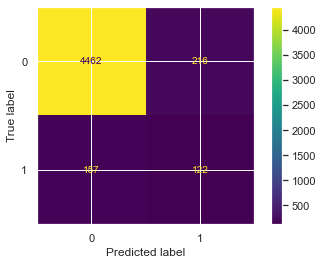

In [26]:
plot_confusion_matrix(SVM_baseline, tfidf_data_test, y_test)

In [27]:
y_pred = model.predict(X_test)

NameError: name 'model' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [ ]:
print("Training Accuracy :", cm.score(X_train, y_train))
print("Testing Accuracy :", cm.score(X_test, y_test))

## Baseline with SMOTE
Used to over-sample the minority class (hate speech).

In [12]:
from imblearn.over_sampling import SMOTE
sm= SMOTE()
smote_X_train, smote_y_train = sm.fit_resample(tfidf_data_train, y_train)
# sm = SMOTE(random_state=35)
# smote_X_train, smote_y_train = sm.fit_sample(tfidf_data_train, y_train)

In [13]:
smote_SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', random_state=15)

In [14]:
%%time
# this cell takes about 4 minutes to run
smote_SVM.fit(smote_X_train, smote_y_train)
smote_SVM_test_preds = smote_SVM.predict(tfidf_data_test)

Wall time: 3min 2s


In [15]:
smote_accuracy = accuracy_score(y_test, smote_SVM_test_preds)
smote_precision = precision_score(y_test, smote_SVM_test_preds)
smote_recall = recall_score(y_test, smote_SVM_test_preds)
smote_f1_score = f1_score(y_test, smote_SVM_test_preds)
smote_weighted_f1_score = f1_score(y_test, smote_SVM_test_preds, average='weighted')


In [16]:
# printing evaluation metrics up to 4th decimal place
print('Testing Metrics for Oversampled SVM Baseline with Lemmatization')
print('Accuracy: {:.4}'.format(smote_accuracy))
print('Precision: {:.4}'.format(smote_precision))
print('Recall: {:.4}'.format(smote_recall))
print('F1 Score: {:.4}'.format(smote_f1_score))
print('Weighted F1 Score: {:.4}'.format(smote_weighted_f1_score))

Testing Metrics for Oversampled SVM Baseline with Lemmatization
Accuracy: 0.9288
Precision: 0.3377
Recall: 0.276
F1 Score: 0.3037
Weighted F1 Score: 0.9254


Looks like SMOTE actually decreased the F1, which also happened with Logistic Regression.

In [17]:
# adding these metrics to evaluation metric dict
metric_dict['Baseline SVM Oversampled with SMOTE'] = {'accuracy': smote_accuracy, 'precision': smote_precision, 'recall': smote_recall, 'f1_score': smote_f1_score, 'weighted_f1': smote_weighted_f1_score}

## Baseline with Tomek Links
Used to under-sample the majority class (not hate speech).

In [18]:
from collections import Counter
from imblearn.under_sampling import TomekLinks # doctest: +NORMALIZE_WHITESPACE

tl = TomekLinks()
tomek_X_train, tomek_y_train = tl.fit_resample(tfidf_data_train, y_train)
print('Resampled dataset shape %s' % Counter(tomek_y_train))

Resampled dataset shape Counter({0: 18627, 1: 1151})


Only removed 48 values from the majority class.

In [19]:
tomek_SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', random_state=15)

In [20]:
%%time
# this cell takes 42 seconds to run
tomek_SVM.fit(tomek_X_train, tomek_y_train)
tomek_logreg_test_preds = tomek_SVM.predict(tfidf_data_test)

Wall time: 32.2 s


In [21]:
tomek_accuracy = accuracy_score(y_test, tomek_logreg_test_preds)
tomek_precision = precision_score(y_test, tomek_logreg_test_preds)
tomek_recall = recall_score(y_test, tomek_logreg_test_preds)
tomek_f1_score = f1_score(y_test, tomek_logreg_test_preds)
tomek_weighted_f1_score = f1_score(y_test, tomek_logreg_test_preds, average='weighted')

In [22]:
# printing evaluation metrics up to 4th decimal place
print('Testing Metrics for Undersampled SVM Baseline with Lemmatization')
print('Accuracy: {:.4}'.format(tomek_accuracy))
print('Precision: {:.4}'.format(tomek_precision))
print('Recall: {:.4}'.format(tomek_recall))
print('F1 Score: {:.4}'.format(tomek_f1_score))
print('F1 Score: {:.4}'.format(tomek_weighted_f1_score))

Testing Metrics for Undersampled SVM Baseline with Lemmatization
Accuracy: 0.9498
Precision: 0.6562
Recall: 0.2258
F1 Score: 0.336
F1 Score: 0.938


In [23]:
# adding these metrics to evaluation metric dict
metric_dict['Baseline SVM Undersampled with Tomek Links'] = {'accuracy': tomek_accuracy,'precision': tomek_precision, 'recall': tomek_recall, 'f1_score': tomek_f1_score, 'weighted_f1': tomek_weighted_f1_score}

## Metrics for All Baselines

In [24]:
pd.DataFrame.from_dict(metric_dict, orient='index')

,precision,recall,f1_score,weighted_f1,accuracy
Baseline SVM,0.360947,0.437276,0.395462,0.928112,NaN
Baseline SVM Oversampled with SMOTE,0.337719,0.275986,0.303748,0.925399,0.928788
Baseline SVM Undersampled with Tomek Links,0.656250,0.225806,0.336000,0.937993,0.949768


- The baseline SVM with `class_weight=balanced` has the highest unweighted F1
- The undersampled baseline has a lower raw F1, but higher weighted F1.

We can take a look at each model's classification report to get a better idea about what's happening.

In [25]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
# class_weight='balanced' Baseline report
print(classification_report(y_test, SVM_test_preds, target_names=target_names))
# Undersampled Baseline report
print(classification_report(y_test, tomek_logreg_test_preds, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.97      0.95      0.96      4678
     class 1       0.36      0.44      0.40       279

    accuracy                           0.92      4957
   macro avg       0.66      0.70      0.68      4957
weighted avg       0.93      0.92      0.93      4957

              precision    recall  f1-score   support

     class 0       0.96      0.99      0.97      4678
     class 1       0.66      0.23      0.34       279

    accuracy                           0.95      4957
   macro avg       0.81      0.61      0.65      4957
weighted avg       0.94      0.95      0.94      4957



There are some differances. But most noteably, the baseline with `class_weight=balanced` predicts the hate speech (1) class much better than the other model. 

Therefore, let's stick with that one and grid search to tune its hyperparameters.

In [26]:
# comparing with other models
pd.DataFrame.from_dict(metric_dict, orient='index')

,precision,recall,f1_score,weighted_f1,accuracy
Baseline SVM,0.360947,0.437276,0.395462,0.928112,NaN
Baseline SVM Oversampled with SMOTE,0.337719,0.275986,0.303748,0.925399,0.928788
Baseline SVM Undersampled with Tomek Links,0.656250,0.225806,0.336000,0.937993,0.949768
